/home/vicky/miniconda3/envs/scrnaseq/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


LOADING PREPROCESSED DATA
Loaded: 11135 cells × 22559 genes
HVGs: 3000

PRINCIPAL COMPONENT ANALYSIS
computing PCA
    with n_comps=50


/home/vicky/miniconda3/envs/scrnaseq/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


    finished (0:00:02)
Computed 50 principal components
Variance explained by PC1: 17.4%
Variance explained by PC1-10: 38.6%
Variance explained by PC1-50: 50.7%
Saved: figures/06_pca_variance.png


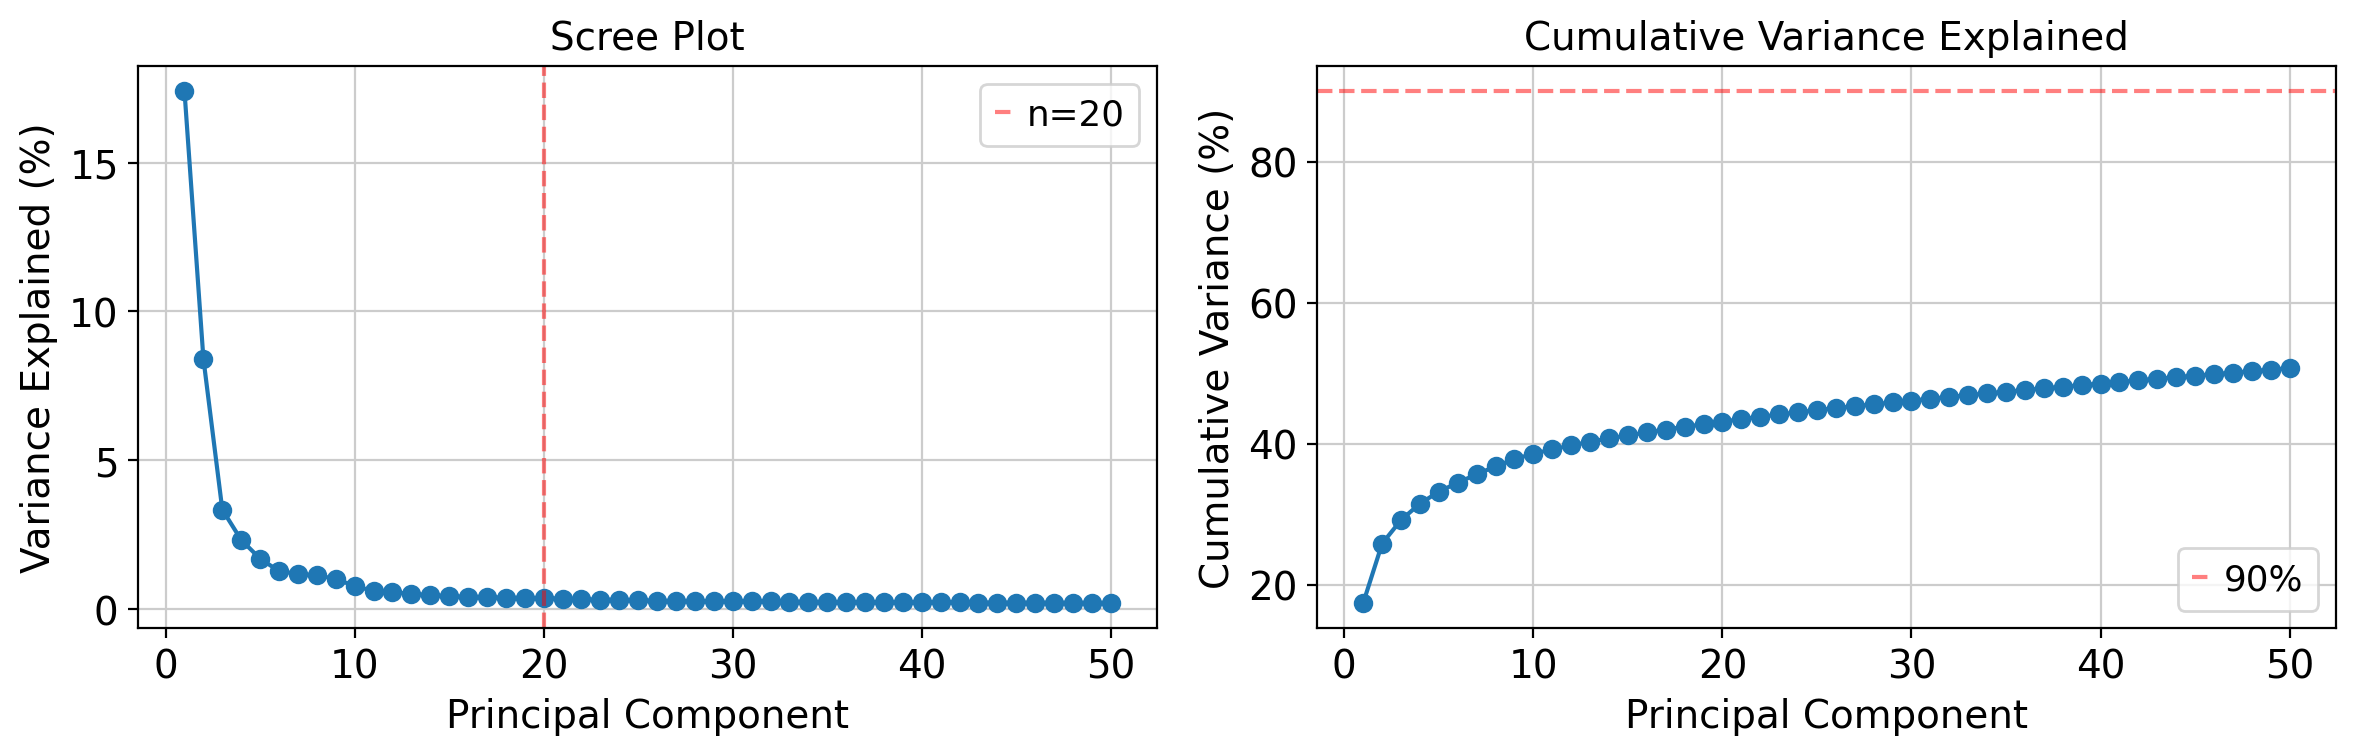

Saved: figures/07_pca_by_condition.png


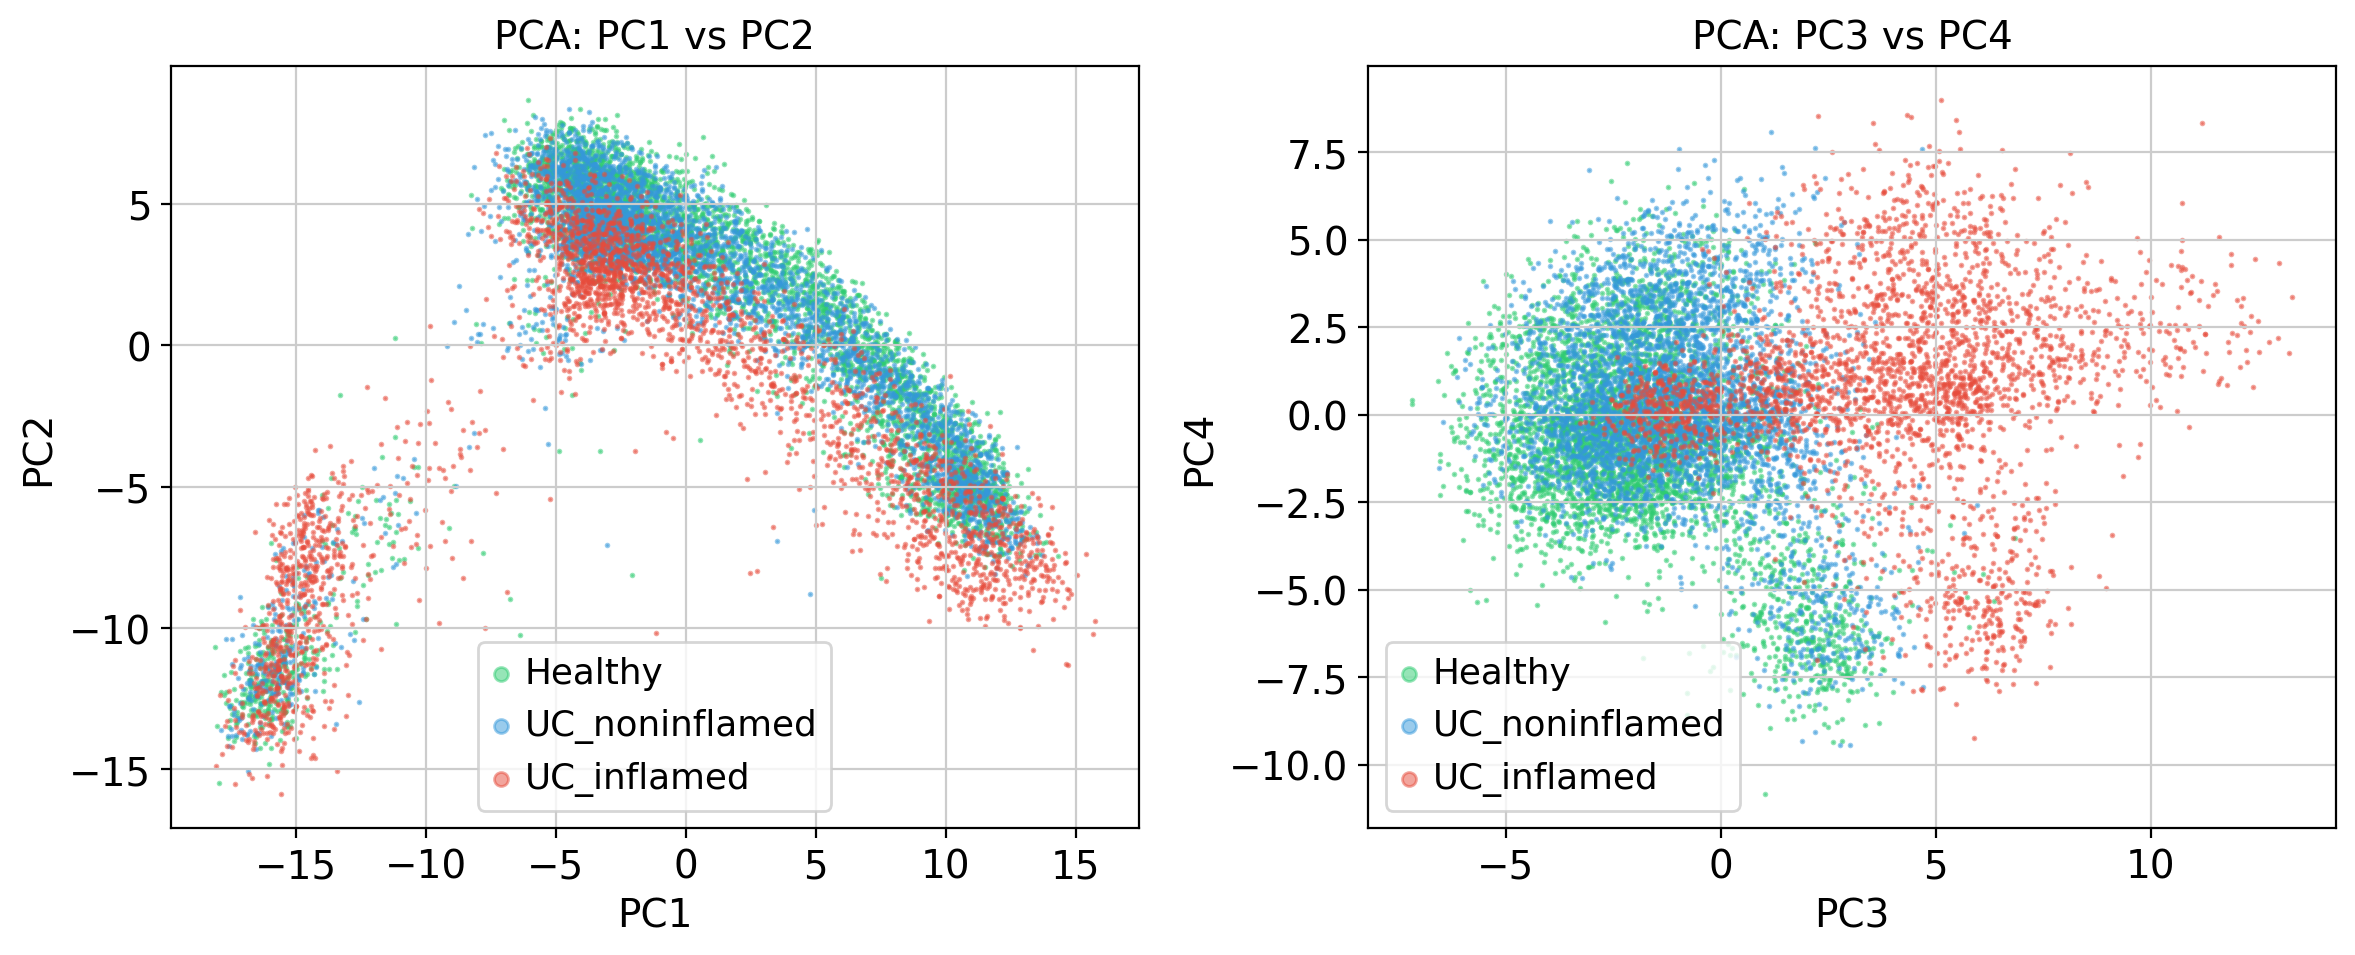


COMPUTING NEIGHBORHOOD GRAPH
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:58)
Computed neighbor graph with n_neighbors=15, n_pcs=30

COMPUTING UMAP EMBEDDING
computing UMAP
    finished (0:00:07)
Computed UMAP embedding

LEIDEN CLUSTERING
running Leiden clustering


/tmp/ipykernel_176014/3686298995.py:174: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added='leiden_0.5')


    finished (0:00:08)
running Leiden clustering
    finished (0:00:06)
running Leiden clustering
    finished (0:00:10)
Clusters at resolution 0.5: 12
Clusters at resolution 1.0: 17
Clusters at resolution 1.5: 27

GENERATING UMAP VISUALIZATIONS
Saved: figures/08_umap_condition.png


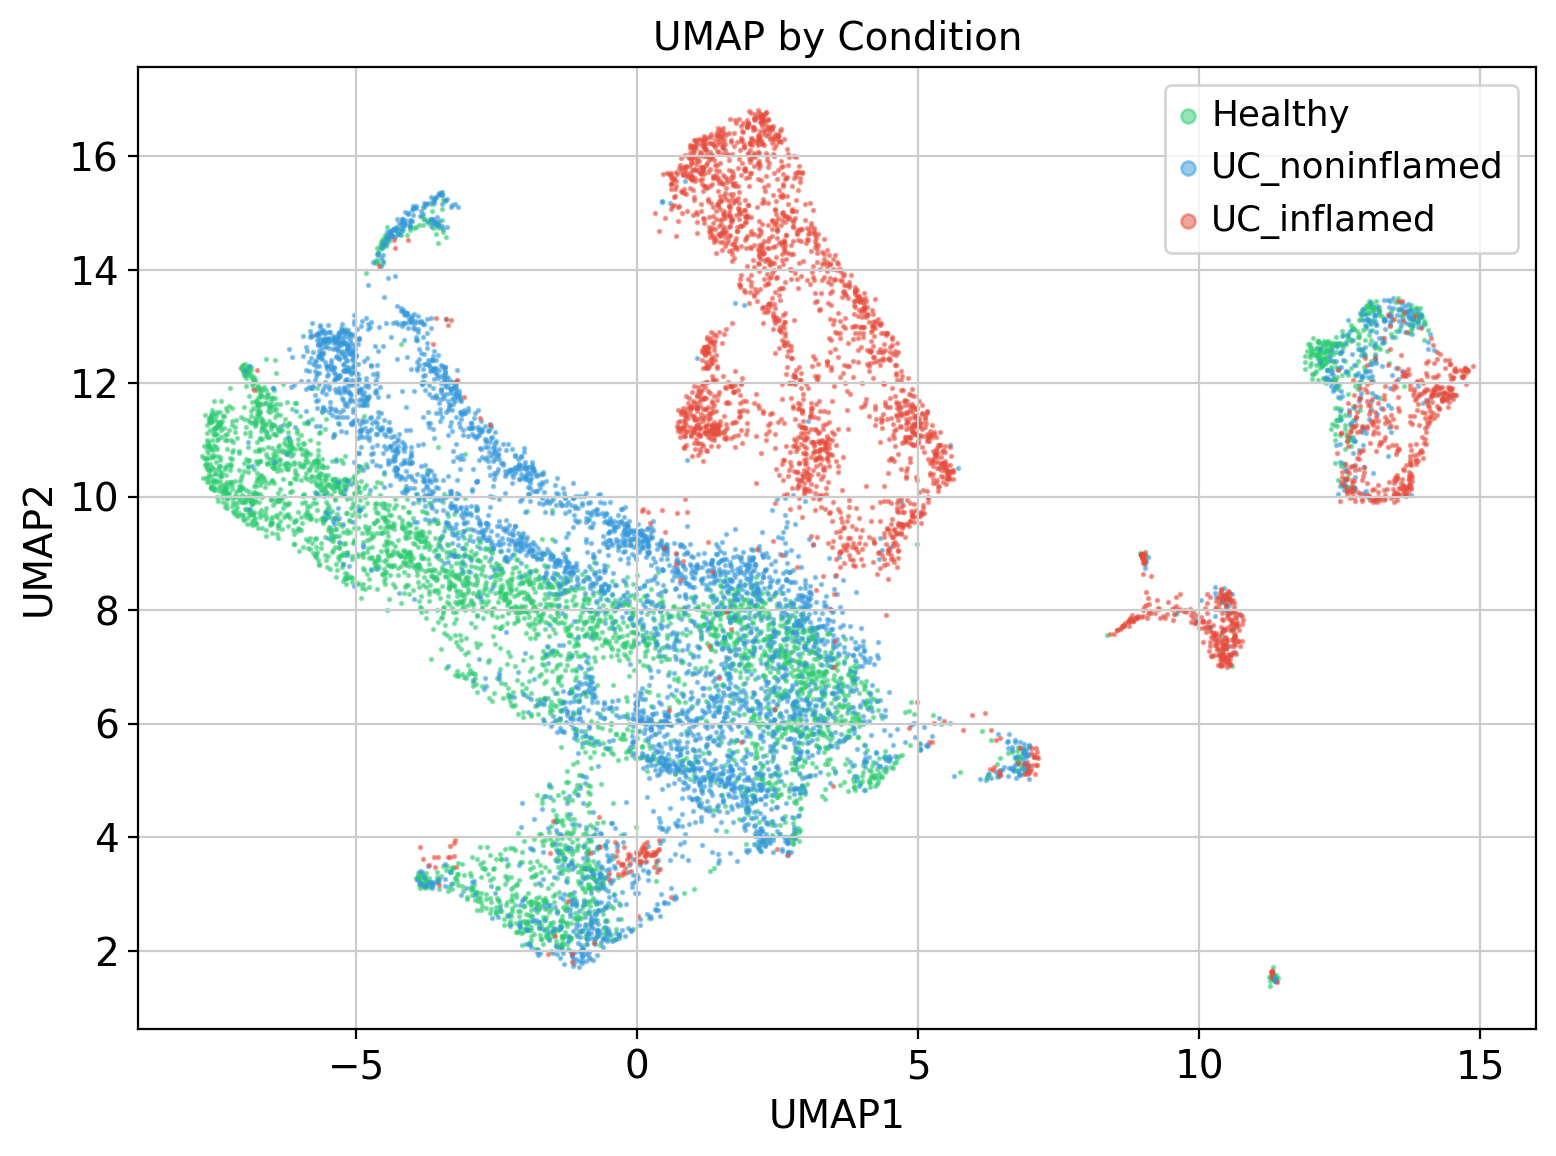

Saved: figures/09_umap_sample.png


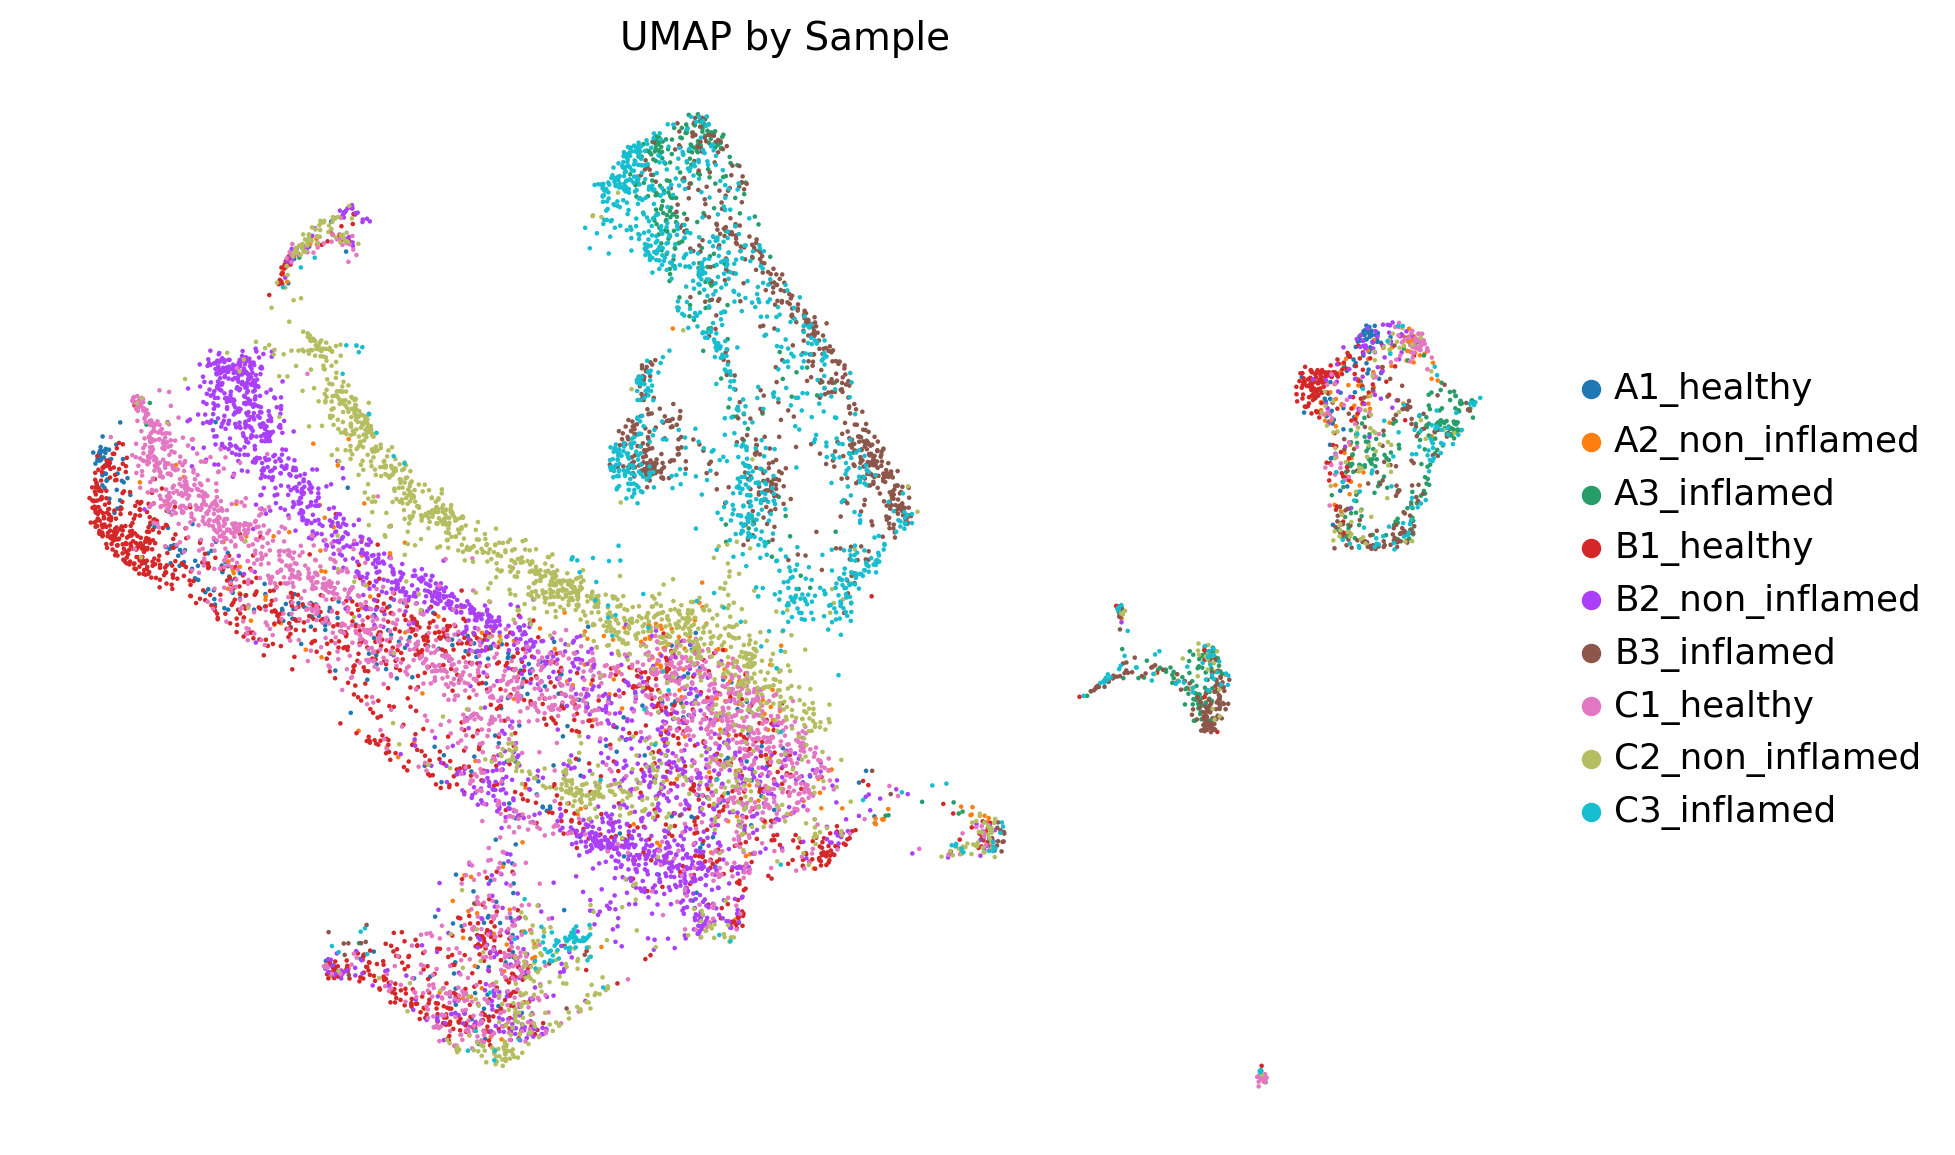

Saved: figures/10_umap_leiden_resolutions.png


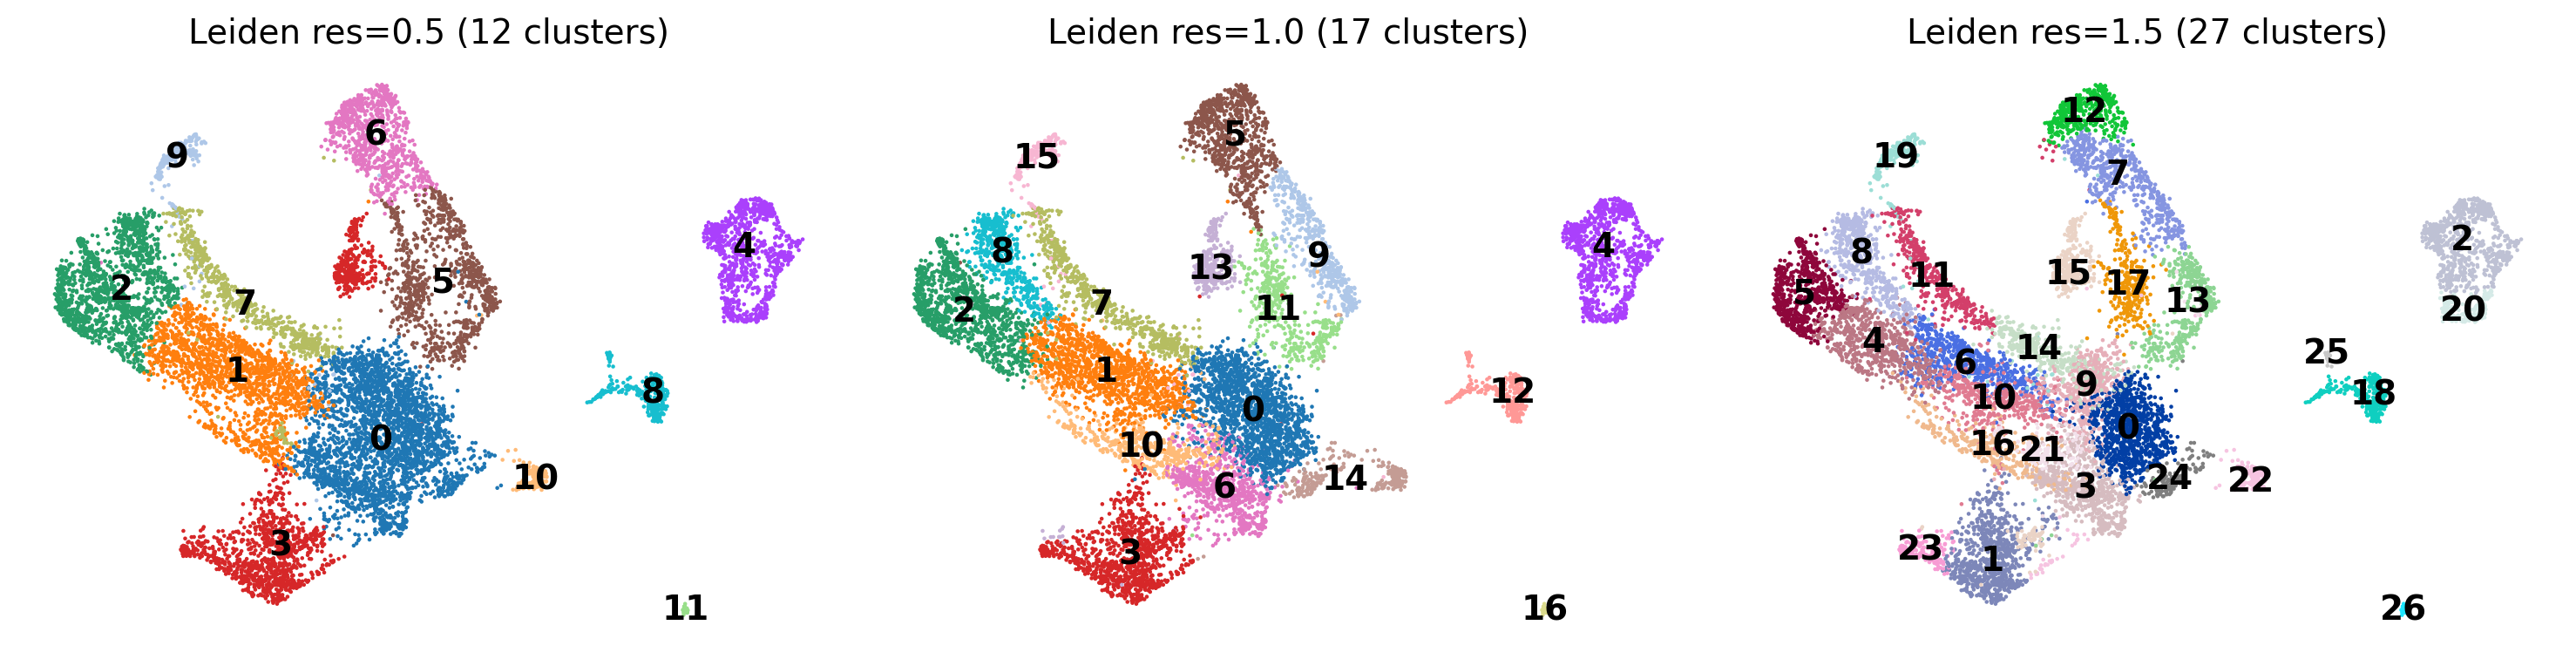


CLUSTER COMPOSITION ANALYSIS

Cluster composition by condition (%):
condition  Healthy  UC_inflamed  UC_noninflamed
leiden                                         
0             50.6          1.1            48.3
1             66.1          0.1            33.8
2             95.1          0.2             4.8
3             57.6          7.1            35.2
4             34.4         42.3            23.3
5              0.1         99.1             0.8
6             26.9          0.3            72.9
7              1.0          4.0            95.0
8              3.2          0.0            96.8
9              0.0         99.6             0.4
10            41.6          1.3            57.0
11             0.2         93.8             5.9
12             5.8         85.1             9.1
13             0.3         99.4             0.3
14            39.5         18.2            42.3
15            37.5          2.2            60.3
16            58.8         23.5            17.6
Saved: figures/11_c

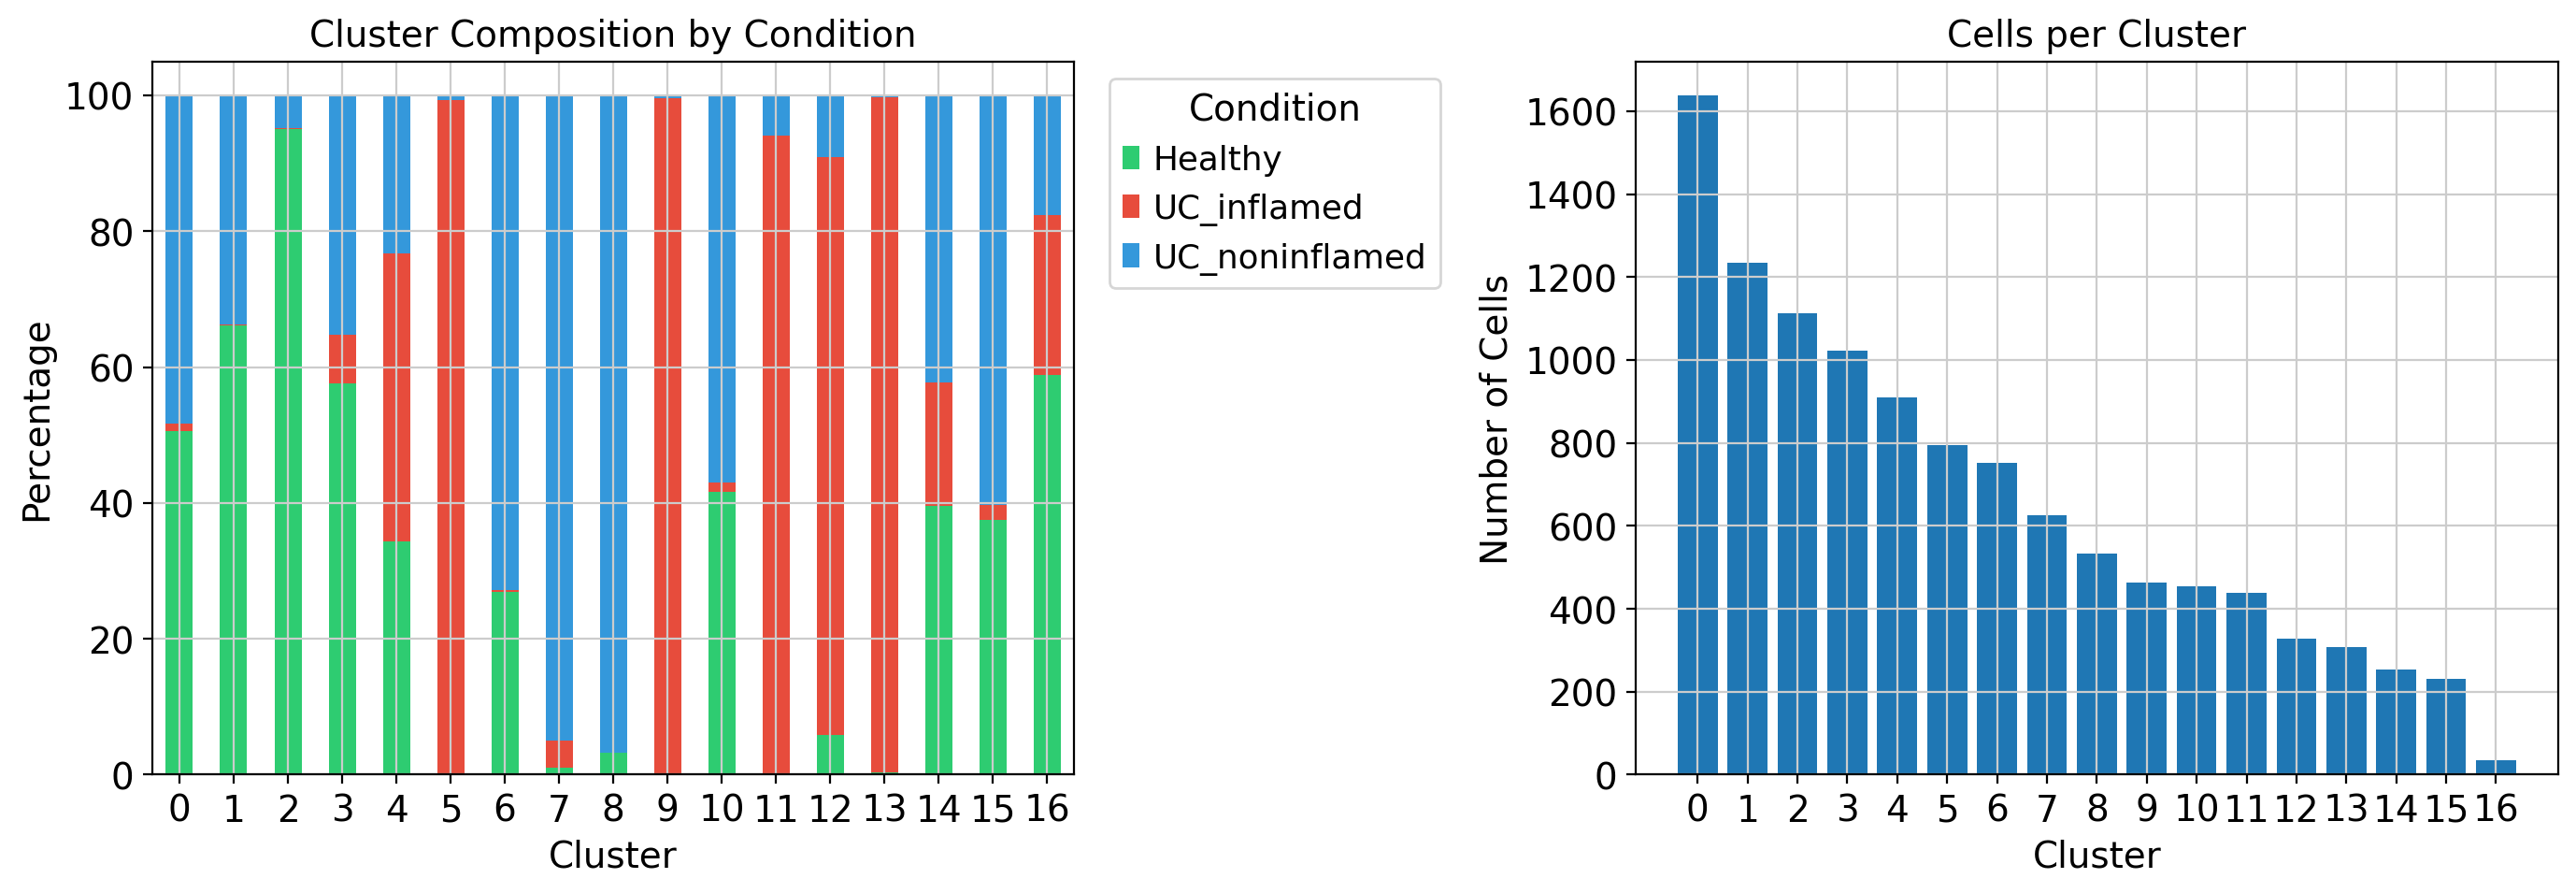


SAVING RESULTS
Saved: data/processed/GSE116222_clustered.h5ad

WEEK 3 SUMMARY

Dimensionality reduction complete:
  PCA: 50 components computed, using 30 for downstream
  UMAP: 2D embedding for visualization
  
Clustering results (resolution 1.0):
  17 clusters identified

Key data stored:
  adata.obsm['X_pca'] - PCA coordinates
  adata.obsm['X_umap'] - UMAP coordinates
  adata.obs['leiden'] - Cluster assignments
  adata.obsp['connectivities'] - Neighbor graph

Figures generated:
  06_pca_variance.png - Scree plot
  07_pca_by_condition.png - PCA colored by condition
  08_umap_condition.png - UMAP by condition
  09_umap_sample.png - UMAP by sample (batch check)
  10_umap_leiden_resolutions.png - Clustering at 3 resolutions
  11_cluster_composition.png - Cluster makeup

Next step: Week 4 - Cell Type Annotation
  Identify what each cluster represents using marker genes.

MARKER GENE PREVIEW

Checking marker genes in dataset:
  Stem cells: 2/2 markers present
  Enterocytes: 3/3 markers pr

In [1]:
#!/usr/bin/env python3
"""
Week 3: Dimensionality Reduction & Clustering for GSE116222
============================================================

Pipeline:
1. PCA - Linear reduction from 3000 HVGs to ~50 principal components
2. Neighbor graph - Connect similar cells based on PC space
3. UMAP - Non-linear projection for visualization
4. Leiden clustering - Community detection to identify cell groups

Key concepts:

WHY REDUCE DIMENSIONS?
- 3000 genes = 3000-dimensional space
- Distance metrics break down in high dimensions ("curse of dimensionality")
- Most variation is captured by far fewer dimensions
- Reduces noise (minor PCs often capture technical variation)

PCA vs UMAP:
- PCA: Linear, preserves global structure, used for computation
- UMAP: Non-linear, preserves local structure, used for visualization
- Never cluster on UMAP coordinates - cluster on PCA/neighbor graph
"""

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Settings
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

# Paths
PROCESSED_DIR = Path("data/processed")
FIGURES_DIR = Path("figures")

# ==============================================================================
# Step 1: Load Preprocessed Data
# ==============================================================================

print("="*60)
print("LOADING PREPROCESSED DATA")
print("="*60)

adata = sc.read_h5ad(PROCESSED_DIR / "GSE116222_preprocessed.h5ad")
print(f"Loaded: {adata.n_obs} cells × {adata.n_vars} genes")
print(f"HVGs: {adata.var['highly_variable'].sum()}")

# ==============================================================================
# Step 2: PCA
# ==============================================================================

print("\n" + "="*60)
print("PRINCIPAL COMPONENT ANALYSIS")
print("="*60)

# PCA on HVGs only
# use_highly_variable=True automatically subsets to HVGs
sc.tl.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

print(f"Computed {adata.obsm['X_pca'].shape[1]} principal components")
print(f"Variance explained by PC1: {adata.uns['pca']['variance_ratio'][0]*100:.1f}%")
print(f"Variance explained by PC1-10: {adata.uns['pca']['variance_ratio'][:10].sum()*100:.1f}%")
print(f"Variance explained by PC1-50: {adata.uns['pca']['variance_ratio'][:50].sum()*100:.1f}%")

# Elbow plot - helps decide how many PCs to use
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Variance ratio per PC
axes[0].plot(range(1, 51), adata.uns['pca']['variance_ratio'] * 100, 'o-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('Scree Plot')
axes[0].axvline(x=20, color='red', linestyle='--', alpha=0.5, label='n=20')
axes[0].legend()

# Cumulative variance
cumvar = np.cumsum(adata.uns['pca']['variance_ratio']) * 100
axes[1].plot(range(1, 51), cumvar, 'o-')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Cumulative Variance (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90%')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "06_pca_variance.png", dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/06_pca_variance.png")
plt.show()

# PCA embedding colored by condition
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

condition_palette = {
    'Healthy': '#2ecc71',
    'UC_noninflamed': '#3498db',
    'UC_inflamed': '#e74c3c'
}

for condition, color in condition_palette.items():
    mask = adata.obs['condition'] == condition
    axes[0].scatter(
        adata.obsm['X_pca'][mask, 0],
        adata.obsm['X_pca'][mask, 1],
        c=color, s=1, alpha=0.5, label=condition
    )
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA: PC1 vs PC2')
axes[0].legend(markerscale=5)

for condition, color in condition_palette.items():
    mask = adata.obs['condition'] == condition
    axes[1].scatter(
        adata.obsm['X_pca'][mask, 2],
        adata.obsm['X_pca'][mask, 3],
        c=color, s=1, alpha=0.5, label=condition
    )
axes[1].set_xlabel('PC3')
axes[1].set_ylabel('PC4')
axes[1].set_title('PCA: PC3 vs PC4')
axes[1].legend(markerscale=5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "07_pca_by_condition.png", dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/07_pca_by_condition.png")
plt.show()

# ==============================================================================
# Step 3: Neighborhood Graph
# ==============================================================================

print("\n" + "="*60)
print("COMPUTING NEIGHBORHOOD GRAPH")
print("="*60)

# Build k-nearest neighbor graph in PC space
# n_neighbors: higher = smoother clusters, lower = finer resolution
# n_pcs: how many PCs to use (typically 20-50)

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
print("Computed neighbor graph with n_neighbors=15, n_pcs=30")

# ==============================================================================
# Step 4: UMAP
# ==============================================================================

print("\n" + "="*60)
print("COMPUTING UMAP EMBEDDING")
print("="*60)

# UMAP projects the neighbor graph to 2D for visualization
# min_dist: lower = tighter clusters, higher = more spread
# spread: scale of the embedding

sc.tl.umap(adata, min_dist=0.3, spread=1.0)
print("Computed UMAP embedding")

# ==============================================================================
# Step 5: Leiden Clustering
# ==============================================================================

print("\n" + "="*60)
print("LEIDEN CLUSTERING")
print("="*60)

# Leiden: community detection algorithm on the neighbor graph
# resolution: higher = more clusters, lower = fewer clusters
# Default resolution=1.0 is often a good starting point

sc.tl.leiden(adata, resolution=0.5, key_added='leiden_0.5')
sc.tl.leiden(adata, resolution=1.0, key_added='leiden_1.0')
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_1.5')

print(f"Clusters at resolution 0.5: {adata.obs['leiden_0.5'].nunique()}")
print(f"Clusters at resolution 1.0: {adata.obs['leiden_1.0'].nunique()}")
print(f"Clusters at resolution 1.5: {adata.obs['leiden_1.5'].nunique()}")

# ==============================================================================
# Step 6: Visualization
# ==============================================================================

print("\n" + "="*60)
print("GENERATING UMAP VISUALIZATIONS")
print("="*60)

# UMAP by condition
fig, ax = plt.subplots(figsize=(8, 6))
for condition, color in condition_palette.items():
    mask = adata.obs['condition'] == condition
    ax.scatter(
        adata.obsm['X_umap'][mask, 0],
        adata.obsm['X_umap'][mask, 1],
        c=color, s=1, alpha=0.5, label=condition
    )
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('UMAP by Condition')
ax.legend(markerscale=5)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "08_umap_condition.png", dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/08_umap_condition.png")
plt.show()

# UMAP by sample
fig, ax = plt.subplots(figsize=(10, 6))
sc.pl.umap(adata, color='sample', ax=ax, show=False, title='UMAP by Sample')
plt.tight_layout()
plt.savefig(FIGURES_DIR / "09_umap_sample.png", dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/09_umap_sample.png")
plt.show()

# UMAP by cluster at different resolutions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sc.pl.umap(adata, color='leiden_0.5', ax=axes[0], show=False, 
           title=f'Leiden res=0.5 ({adata.obs["leiden_0.5"].nunique()} clusters)', legend_loc='on data')
sc.pl.umap(adata, color='leiden_1.0', ax=axes[1], show=False,
           title=f'Leiden res=1.0 ({adata.obs["leiden_1.0"].nunique()} clusters)', legend_loc='on data')
sc.pl.umap(adata, color='leiden_1.5', ax=axes[2], show=False,
           title=f'Leiden res=1.5 ({adata.obs["leiden_1.5"].nunique()} clusters)', legend_loc='on data')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "10_umap_leiden_resolutions.png", dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/10_umap_leiden_resolutions.png")
plt.show()

# ==============================================================================
# Step 7: Cluster Composition Analysis
# ==============================================================================

print("\n" + "="*60)
print("CLUSTER COMPOSITION ANALYSIS")
print("="*60)

# Using resolution 1.0 as default
adata.obs['leiden'] = adata.obs['leiden_1.0']

# Cross-tabulation: clusters vs conditions
cluster_condition = pd.crosstab(
    adata.obs['leiden'], 
    adata.obs['condition'],
    normalize='index'  # Proportion within each cluster
) * 100

print("\nCluster composition by condition (%):")
print(cluster_condition.round(1))

# Visualize cluster composition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
cluster_condition.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[0],
    color=[condition_palette[c] for c in cluster_condition.columns]
)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Percentage')
axes[0].set_title('Cluster Composition by Condition')
axes[0].legend(title='Condition', bbox_to_anchor=(1.02, 1))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Cells per cluster
cluster_counts = adata.obs['leiden'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Cells')
axes[1].set_title('Cells per Cluster')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "11_cluster_composition.png", dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/11_cluster_composition.png")
plt.show()

# ==============================================================================
# Step 8: Save Results
# ==============================================================================

print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

adata.write_h5ad(PROCESSED_DIR / "GSE116222_clustered.h5ad")
print(f"Saved: {PROCESSED_DIR}/GSE116222_clustered.h5ad")

# ==============================================================================
# Summary
# ==============================================================================

print("\n" + "="*60)
print("WEEK 3 SUMMARY")
print("="*60)

print(f"""
Dimensionality reduction complete:
  PCA: 50 components computed, using 30 for downstream
  UMAP: 2D embedding for visualization
  
Clustering results (resolution 1.0):
  {adata.obs['leiden'].nunique()} clusters identified

Key data stored:
  adata.obsm['X_pca'] - PCA coordinates
  adata.obsm['X_umap'] - UMAP coordinates
  adata.obs['leiden'] - Cluster assignments
  adata.obsp['connectivities'] - Neighbor graph

Figures generated:
  06_pca_variance.png - Scree plot
  07_pca_by_condition.png - PCA colored by condition
  08_umap_condition.png - UMAP by condition
  09_umap_sample.png - UMAP by sample (batch check)
  10_umap_leiden_resolutions.png - Clustering at 3 resolutions
  11_cluster_composition.png - Cluster makeup

Next step: Week 4 - Cell Type Annotation
  Identify what each cluster represents using marker genes.
""")

# ==============================================================================
# Quick Marker Check (Preview of Week 4)
# ==============================================================================

print("="*60)
print("MARKER GENE PREVIEW")
print("="*60)

# Check a few known markers
markers = {
    'Stem cells': ['LGR5', 'ASCL2'],
    'Enterocytes': ['CA1', 'SLC26A3', 'FABP1'],
    'Goblet cells': ['MUC2', 'TFF3', 'ZG16'],
    'Enteroendocrine': ['CHGA', 'PYY', 'GCG'],
    'BEST4+ cells': ['BEST4', 'OTOP2'],
    'Colonocytes': ['CA2', 'AQP8']
}

print("\nChecking marker genes in dataset:")
for cell_type, genes in markers.items():
    present = [g for g in genes if g in adata.var_names]
    missing = [g for g in genes if g not in adata.var_names]
    print(f"  {cell_type}: {len(present)}/{len(genes)} markers present")
    if missing:
        print(f"    Missing: {missing}")